In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import pickle # To save the model
from functools import partial
import random



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


import os
from os.path import isfile

--2024-03-18 11:37:29--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.72K  --.-KB/s    in 0s      

2024-03-18 11:37:29 (98.7 MB/s) - ‘visualization.py’ saved [13023/13023]



# Download the dataset and train/test split

Load the dataset

In [2]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2024-03-18 11:37:41--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.004s  

2024-03-18 11:37:41 (58.5 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2024-03-18 11:37:41--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

In [3]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time", "task-clock", "cpu-clock", "ref-cycles", "bus-cycles", "cycles"])
#full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()
print (data)

[[1.83684800e+06 1.90327023e+08 1.16151881e+08 ... 2.13000000e+02
  0.00000000e+00 0.00000000e+00]
 [1.85564100e+06 1.90782590e+08 1.16159726e+08 ... 2.38000000e+02
  0.00000000e+00 0.00000000e+00]
 [1.85637300e+06 1.90688064e+08 1.16229597e+08 ... 2.13000000e+02
  0.00000000e+00 0.00000000e+00]
 ...
 [4.63221500e+06 1.75145145e+08 9.35510160e+07 ... 2.01000000e+02
  0.00000000e+00 2.00000000e+00]
 [4.64478900e+06 1.75105471e+08 9.33248380e+07 ... 2.13000000e+02
  0.00000000e+00 2.00000000e+00]
 [4.63646600e+06 1.75154689e+08 9.35143800e+07 ... 2.13000000e+02
  0.00000000e+00 2.00000000e+00]]


In [4]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,...,iTLB-load-misses,iTLB-loads,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,...,2595.0,8.0,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,...,2557.0,0.0,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,...,2595.0,8.0,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,...,2645.0,0.0,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,...,2914.0,0.0,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,0


In [5]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 27)
Possible labels  [0 1 2]


In [6]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

#PCA Analysis

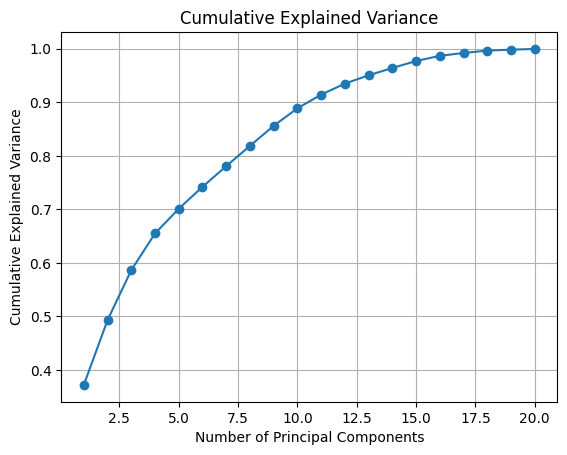

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.834204 -0.606137 -0.010219 -0.025383  0.241252 -0.129533  0.043874   
1 -3.828635 -0.599534 -0.008103 -0.022358  0.241058 -0.126888  0.039971   
2 -3.844812 -0.605587 -0.009674 -0.030481  0.275061 -0.135692  0.039885   
3 -3.864735 -0.606534  0.004541 -0.041463  0.307717 -0.124318  0.042452   
4 -3.808948 -0.574182  0.002829 -0.074507  0.237876 -0.156275  0.051921   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.255289 -0.046533  0.360354  0.099318  0.009256  0.187147  0.116206   
1 -0.256092 -0.051279  0.351794  0.109400  0.010308  0.194480  0.125899   
2 -0.261068 -0.050193  0.356307  0.108280  0.068734  0.192601  0.165792   
3 -0.266911 -0.060281  0.350660  0.061452  0.044528  0.259424  0.144939   
4 -0.261542 -0.015342  0.336540  0.117054  0.048140  0.184461  0.127312   

       PC15      PC16      PC17      PC18      PC19      PC20  
0 -0.045131  0.193653  0.084085  0

In [7]:
## Standardize the data
full_df_no_labels = full_df.drop(columns=["label"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(full_df_no_labels)

# Initialize PCA and specify the number of components you want to keep
num_components = 20  # You can choose a different number based on your analysis
pca = PCA(n_components=num_components)
# Fit PCA to the scaled data
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i}' for i in range(1, num_components + 1)])

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plotting the explained variance
plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)  # Add grid
plt.show()

# Display the DataFrame with the principal components
print(pca_df.head())


Top features contributing to PC1:
               Feature   Loading
2     L1-dcache-stores  0.287983
16         dTLB-stores  0.287953
19        instructions  0.269572
8   branch-load-misses  0.266573
9        branch-misses  0.266505


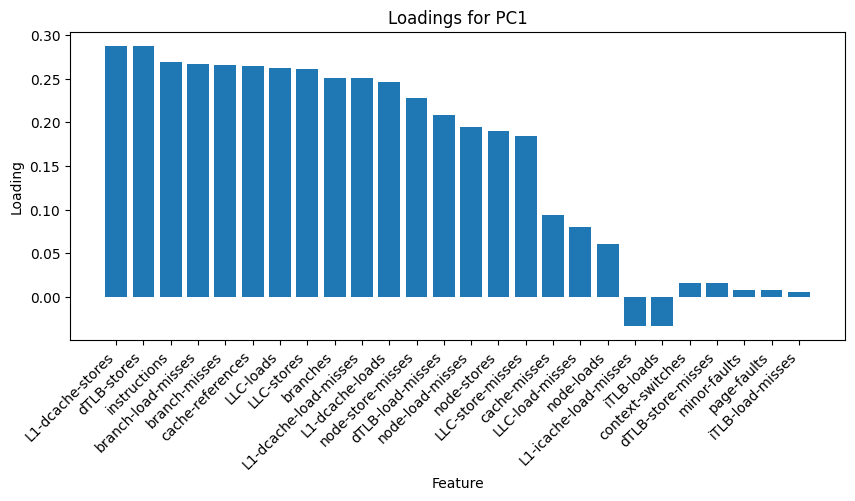


Top features contributing to PC2:
                  Feature   Loading
14       dTLB-load-misses -0.289791
5               LLC-loads -0.276411
12       cache-references -0.273680
0   L1-dcache-load-misses -0.262304
11           cache-misses  0.260032


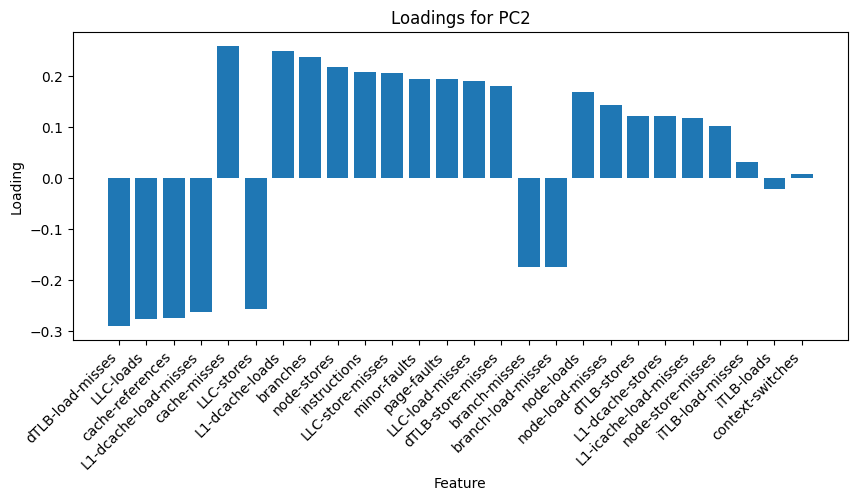


Top features contributing to PC3:
                  Feature   Loading
25            page-faults  0.497898
20           minor-faults  0.497898
3   L1-icache-load-misses  0.386821
1         L1-dcache-loads -0.225725
19           instructions -0.195409


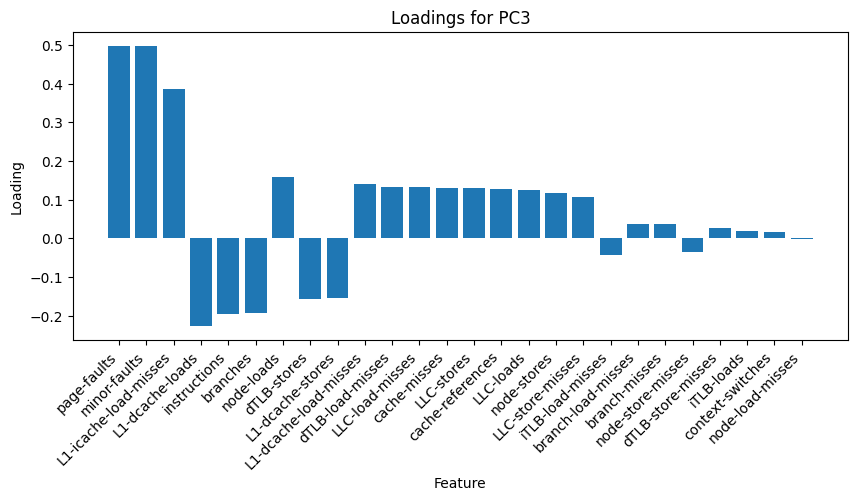


Top features contributing to PC4:
            Feature   Loading
4   LLC-load-misses -0.497740
22       node-loads -0.418554
11     cache-misses -0.409951
25      page-faults  0.315086
20     minor-faults  0.315086


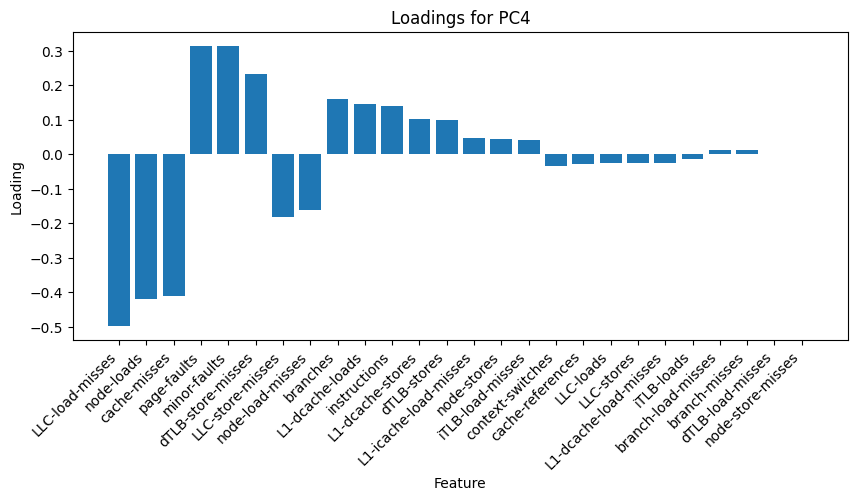


Top features contributing to PC5:
              Feature   Loading
15  dTLB-store-misses  0.514679
23  node-store-misses -0.345287
22         node-loads  0.298328
13   context-switches  0.265712
6    LLC-store-misses -0.263823


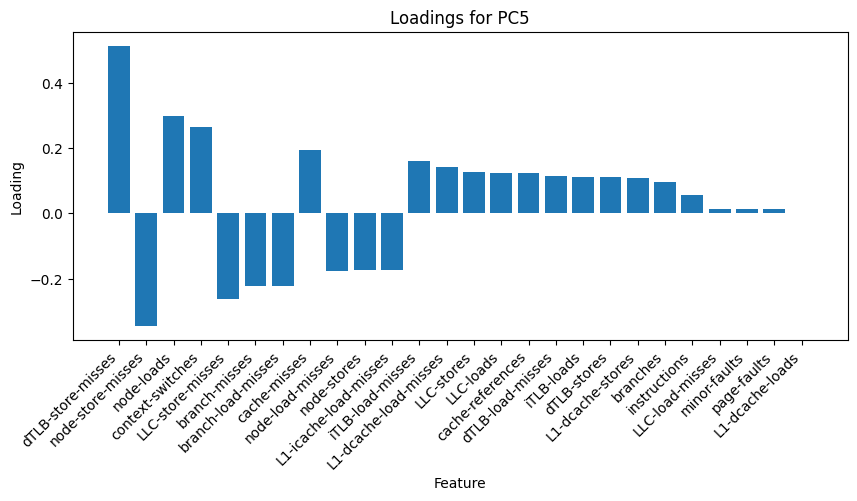


Top features contributing to PC6:
                  Feature   Loading
13       context-switches  0.653812
3   L1-icache-load-misses  0.363843
6        LLC-store-misses  0.342478
22             node-loads -0.309798
11           cache-misses -0.188720


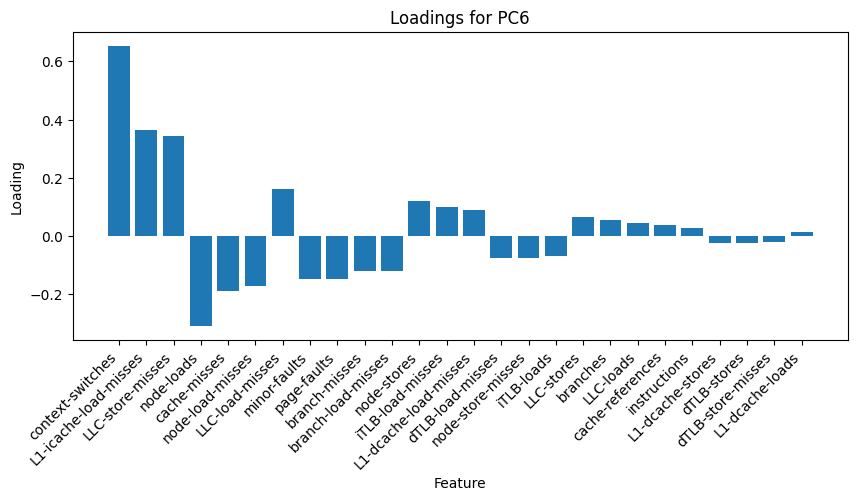


Top features contributing to PC7:
              Feature   Loading
17   iTLB-load-misses  0.925260
15  dTLB-store-misses -0.287053
18         iTLB-loads -0.193031
20       minor-faults  0.065765
25        page-faults  0.065765


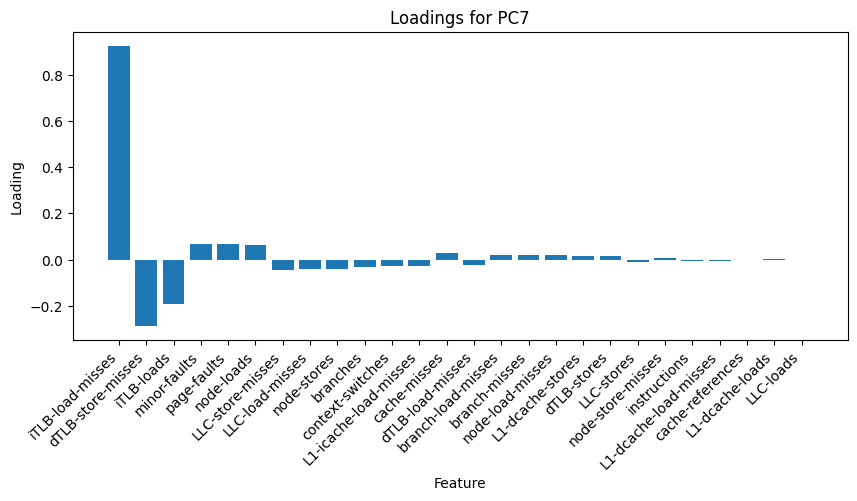


Top features contributing to PC8:
             Feature   Loading
18        iTLB-loads  0.956448
17  iTLB-load-misses  0.198794
6   LLC-store-misses  0.121796
22        node-loads -0.088934
4    LLC-load-misses  0.083455


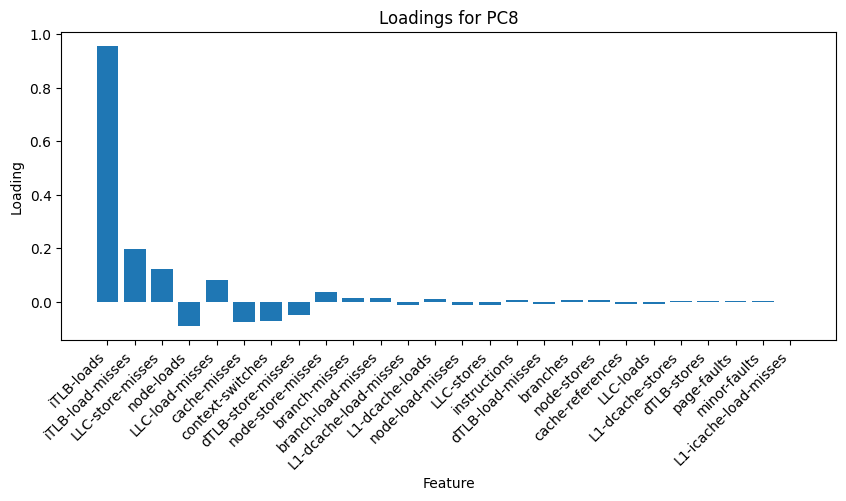


Top features contributing to PC9:
              Feature   Loading
13   context-switches  0.633060
15  dTLB-store-misses -0.377695
4     LLC-load-misses -0.325621
6    LLC-store-misses -0.310243
21   node-load-misses  0.226448


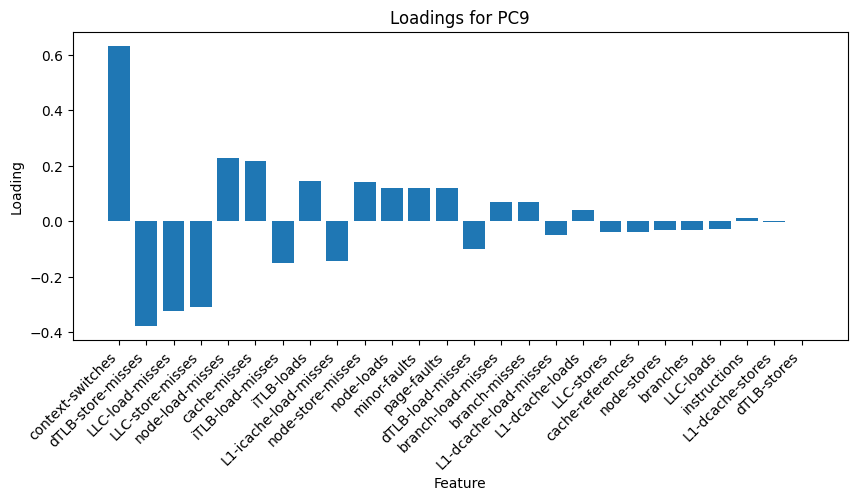


Top features contributing to PC10:
                  Feature   Loading
3   L1-icache-load-misses -0.537209
24            node-stores -0.446965
4         LLC-load-misses  0.417203
25            page-faults  0.264081
20           minor-faults  0.264081


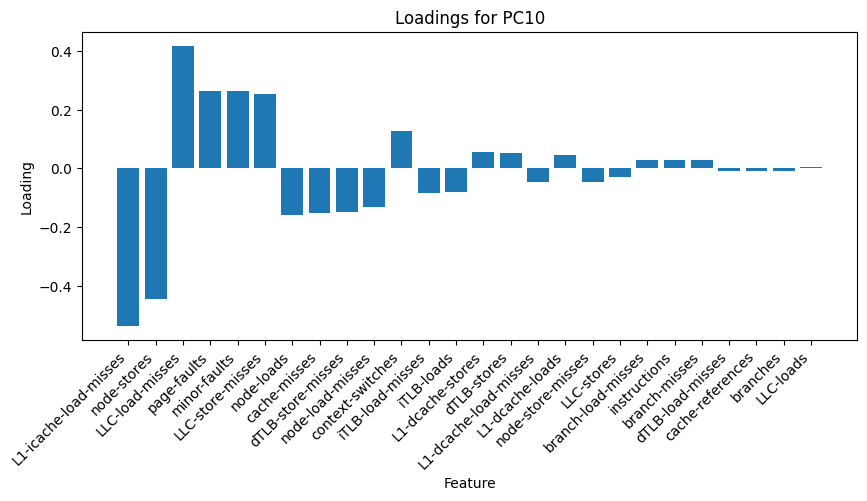


Top features contributing to PC11:
                  Feature   Loading
15      dTLB-store-misses  0.566045
21       node-load-misses  0.364021
23      node-store-misses  0.247650
3   L1-icache-load-misses -0.227156
13       context-switches  0.220368


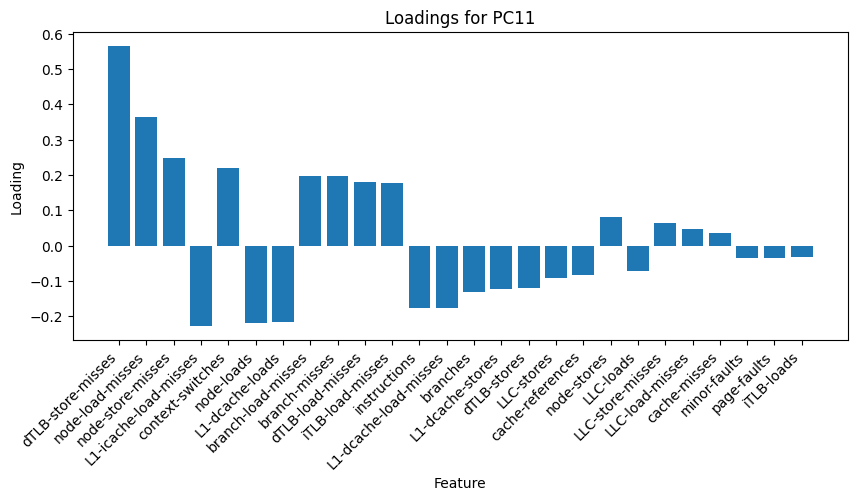


Top features contributing to PC12:
               Feature   Loading
21    node-load-misses  0.583441
22          node-loads -0.497287
9        branch-misses -0.328289
8   branch-load-misses -0.328237
11        cache-misses  0.235372


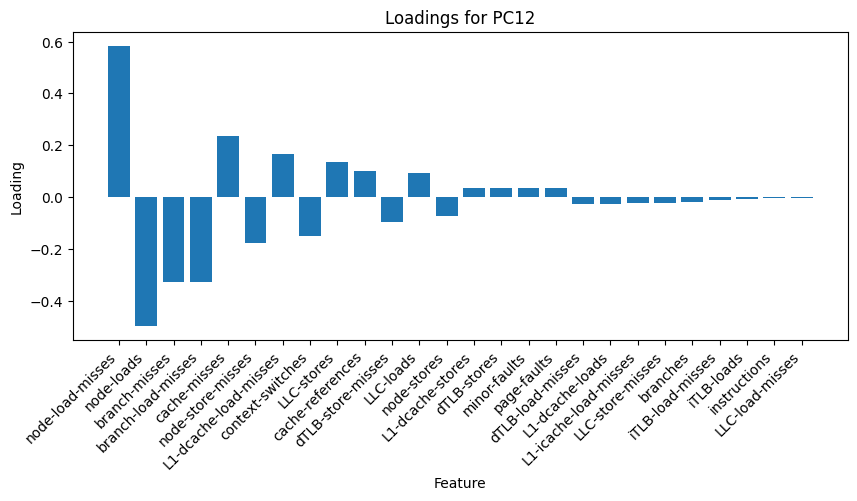


Top features contributing to PC13:
                  Feature   Loading
24            node-stores  0.552491
11           cache-misses  0.428981
21       node-load-misses -0.389648
22             node-loads -0.332369
3   L1-icache-load-misses -0.273495


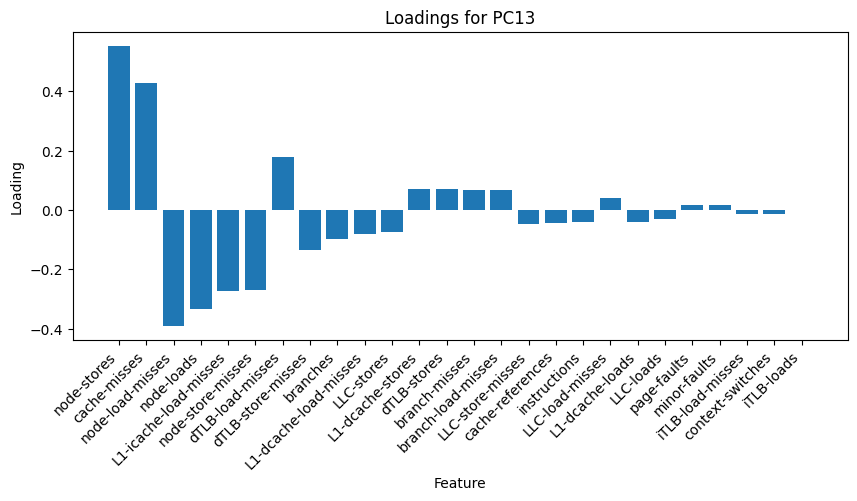


Top features contributing to PC14:
                  Feature   Loading
24            node-stores  0.490340
14       dTLB-load-misses -0.412649
11           cache-misses -0.407469
3   L1-icache-load-misses -0.358322
23      node-store-misses -0.326653


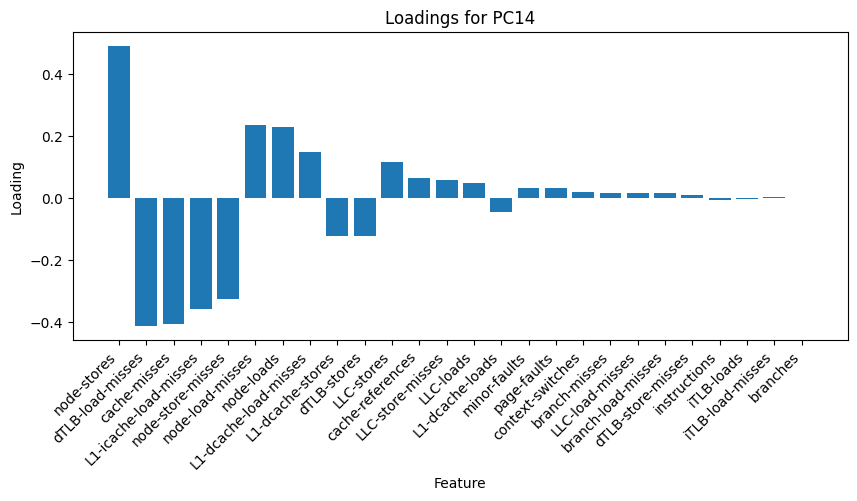


Top features contributing to PC15:
                  Feature   Loading
23      node-store-misses -0.655602
14       dTLB-load-misses  0.363191
21       node-load-misses  0.311079
3   L1-icache-load-misses  0.210975
7              LLC-stores -0.209988


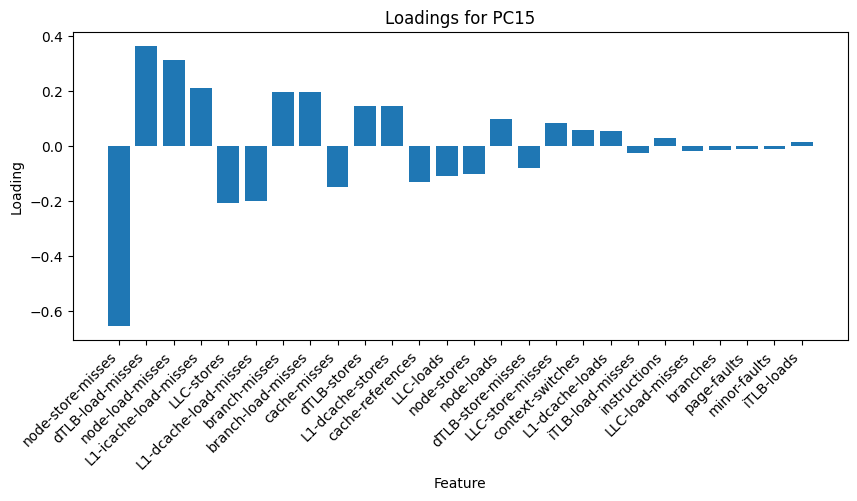


Top features contributing to PC16:
               Feature   Loading
14    dTLB-load-misses  0.586989
8   branch-load-misses -0.361933
9        branch-misses -0.361004
11        cache-misses -0.334383
24         node-stores  0.269091


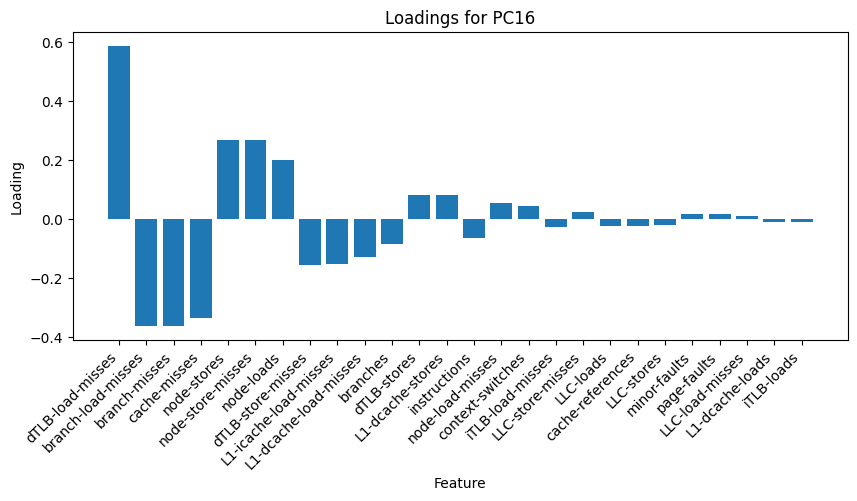


Top features contributing to PC17:
                  Feature   Loading
6        LLC-store-misses  0.688140
4         LLC-load-misses -0.596193
11           cache-misses  0.211301
3   L1-icache-load-misses -0.182585
22             node-loads  0.133351


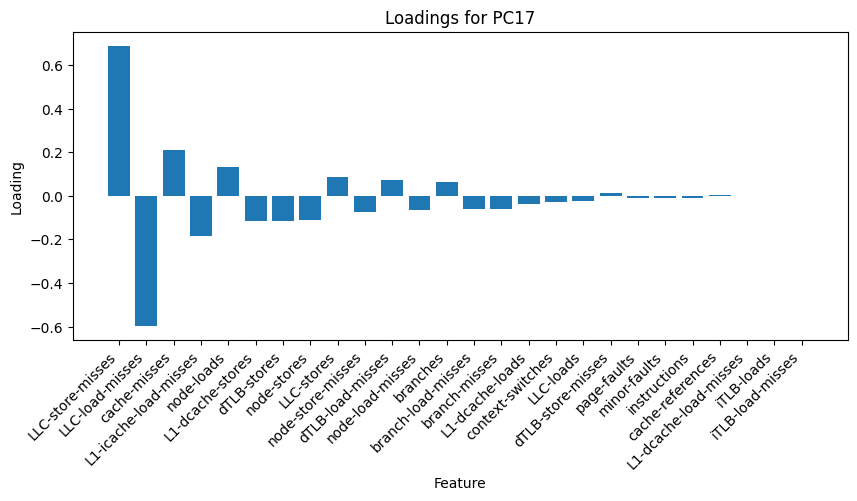


Top features contributing to PC18:
             Feature   Loading
10          branches -0.553950
16       dTLB-stores  0.485231
2   L1-dcache-stores  0.483700
14  dTLB-load-misses -0.289580
1    L1-dcache-loads -0.211938


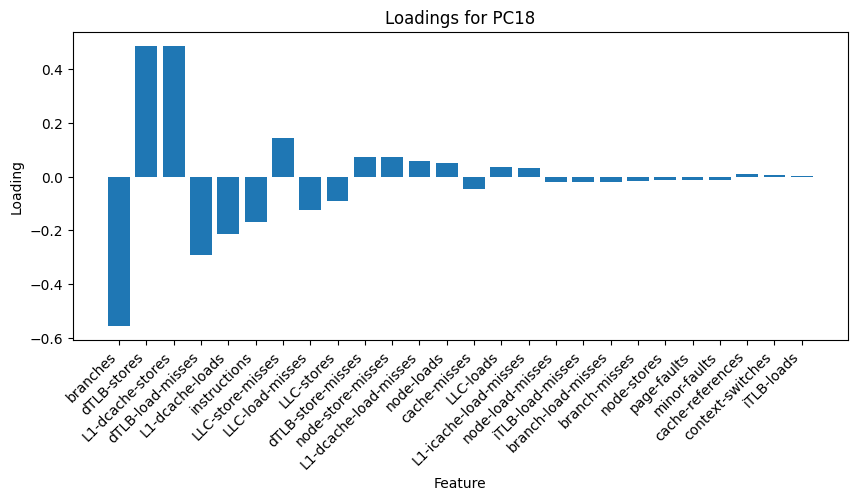


Top features contributing to PC19:
                  Feature   Loading
0   L1-dcache-load-misses  0.627490
7              LLC-stores -0.583023
1         L1-dcache-loads  0.350717
10               branches -0.263611
16            dTLB-stores -0.130349


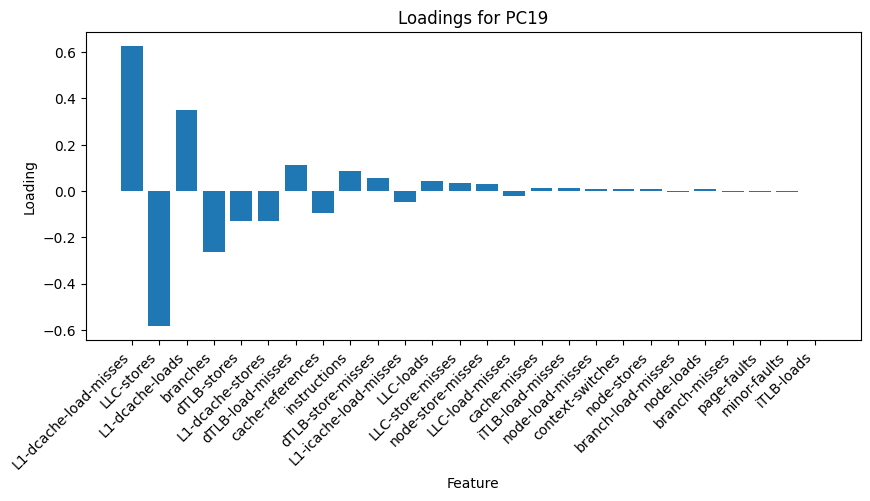


Top features contributing to PC20:
                  Feature   Loading
5               LLC-loads -0.639173
7              LLC-stores  0.492046
12       cache-references -0.387637
0   L1-dcache-load-misses  0.380686
10               branches -0.132428


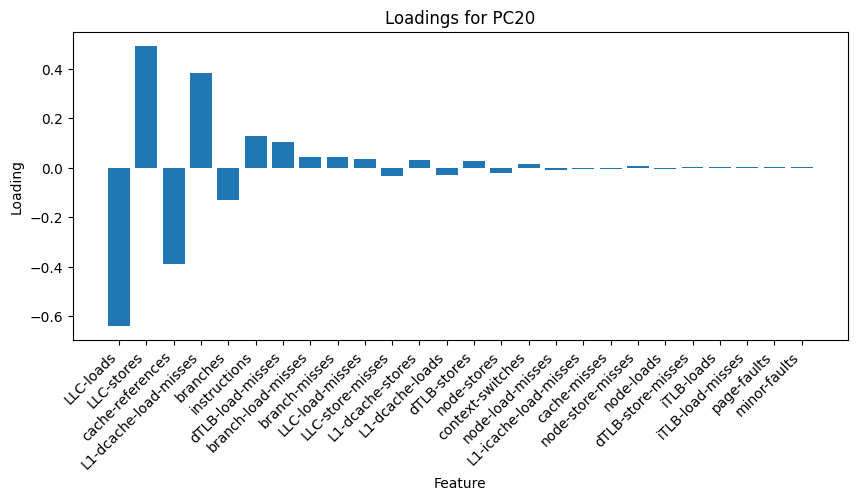

In [8]:
# Access the loadings (coefficients) of each original feature for the first few principal components
for i in range(1, num_components + 1):
    loadings_i = pca.components_[i-1]
    component_name = f'PC{i}'
    loading_df = pd.DataFrame({'Feature': full_df_no_labels.columns, 'Loading': loadings_i})
    loading_df = loading_df.sort_values(by='Loading', key=abs, ascending=False)

    # Display the top features contributing to each component
    print(f"\nTop features contributing to {component_name}:")
    print(loading_df.head())

    # Optionally, you can visualize the loadings
    plt.figure(figsize=(10, 4))
    plt.bar(loading_df['Feature'], loading_df['Loading'])
    plt.title(f'Loadings for {component_name}')
    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.xticks(rotation=45, ha='right')
    plt.show()


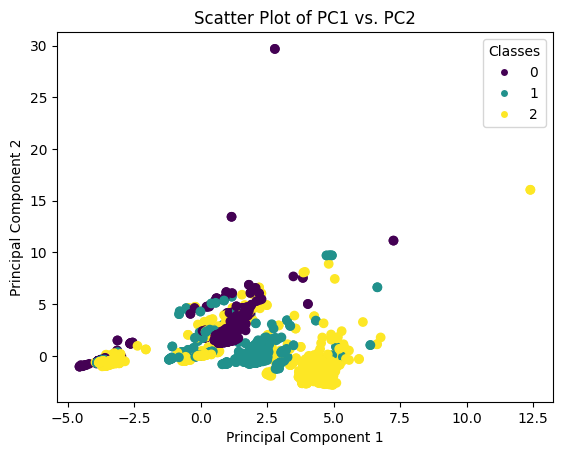

In [9]:
# Combine principal components with target variable
pca_combined = pd.concat([pca_df, full_df['label']], axis=1)

# Scatter Plot of PC1 vs. PC2
scatter_plot = plt.scatter(pca_combined['PC1'], pca_combined['PC2'], c=full_df['label'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC1 vs. PC2')
# Create a legend
legend_labels = full_df['label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=scatter_plot.cmap(scatter_plot.norm(label))) for label in legend_labels]
plt.legend(handles=legend_handles, title='Classes')
plt.show()

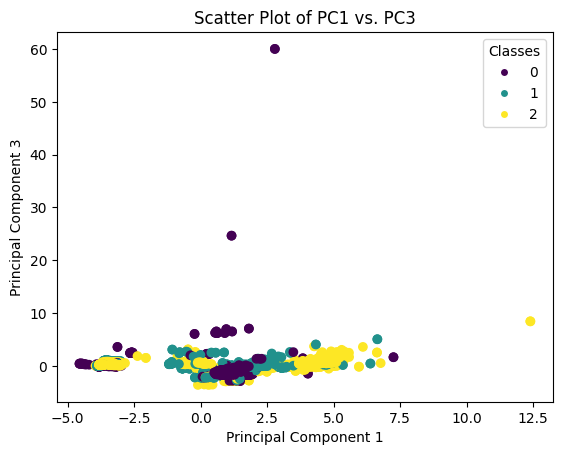

In [10]:
# Combine principal components with target variable
pca_combined = pd.concat([pca_df, full_df['label']], axis=1)

# Scatter Plot of PC1 vs. PC3
scatter_plot = plt.scatter(pca_combined['PC1'], pca_combined['PC3'], c=full_df['label'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Scatter Plot of PC1 vs. PC3')
# Create a legend
legend_labels = full_df['label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=scatter_plot.cmap(scatter_plot.norm(label))) for label in legend_labels]
plt.legend(handles=legend_handles, title='Classes')
plt.show()

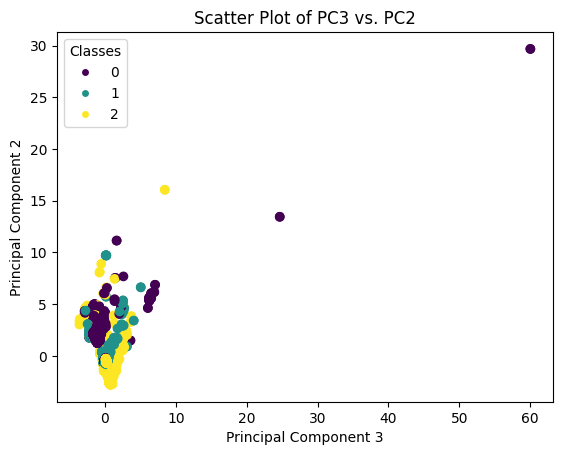

In [11]:
# Combine principal components with target variable
pca_combined = pd.concat([pca_df, full_df['label']], axis=1)

# Scatter Plot of PC3 vs. PC2
scatter_plot = plt.scatter(pca_combined['PC3'], pca_combined['PC2'], c=full_df['label'], cmap='viridis')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC3 vs. PC2')
# Create a legend
legend_labels = full_df['label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=scatter_plot.cmap(scatter_plot.norm(label))) for label in legend_labels]
plt.legend(handles=legend_handles, title='Classes')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming 'target' is the column with class labels
class_labels = full_df['label']

# Combine principal components with class labels
pca_combined = pd.concat([pca_df, class_labels], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,  # Adjust the test size based on your preference
    random_state=42
)

# Initialize and train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print('The Classification report of SVM with all clock cycle features removed')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


The Classification report of SVM with all clock cycle features removed
Accuracy: 0.8137339055793992
Confusion Matrix:
[[368   5   1]
 [ 90 266  20]
 [ 89  12 314]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.98      0.80       374
           1       0.94      0.71      0.81       376
           2       0.94      0.76      0.84       415

    accuracy                           0.81      1165
   macro avg       0.85      0.82      0.81      1165
weighted avg       0.85      0.81      0.82      1165



In [13]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Initialize and train a Logistic Regression classifier
logreg_classifier = LogisticRegression(max_iter=1000, random_state=42)
logreg_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_classifier.predict(X_test)

# Evaluate the performance of the Logistic Regression classifier
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_rep_logreg = classification_report(y_test, y_pred_logreg)

print('The Classification report of Logistic Regression with all clock cycle features removed')
print(f'Accuracy (Logistic Regression): {accuracy_logreg}')
print('Confusion Matrix (Logistic Regression):')
print(conf_matrix_logreg)
print('Classification Report (Logistic Regression):')
print(classification_rep_logreg)

The Classification report of Logistic Regression with all clock cycle features removed
Accuracy (Logistic Regression): 0.8060085836909872
Confusion Matrix (Logistic Regression):
[[357   9   8]
 [ 88 267  21]
 [ 26  74 315]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       374
           1       0.76      0.71      0.74       376
           2       0.92      0.76      0.83       415

    accuracy                           0.81      1165
   macro avg       0.81      0.81      0.80      1165
weighted avg       0.82      0.81      0.80      1165



In [14]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print('The Classification report of Decision Tree with all clock cycle features removed')
print(f'Accuracy (Decision Tree): {accuracy_dt}')
print('Confusion Matrix (Decision Tree):')
print(conf_matrix_dt)
print('Classification Report (Decision Tree):')
print(classification_rep_dt)

The Classification report of Decision Tree with all clock cycle features removed
Accuracy (Decision Tree): 0.9776824034334763
Confusion Matrix (Decision Tree):
[[372   1   1]
 [  3 368   5]
 [  5  11 399]]
Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       374
           1       0.97      0.98      0.97       376
           2       0.99      0.96      0.97       415

    accuracy                           0.98      1165
   macro avg       0.98      0.98      0.98      1165
weighted avg       0.98      0.98      0.98      1165



In [15]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print('The Classification report of Random Forest with all clock cycle features removed')
print(f'Accuracy (Random Forest): {accuracy_rf}')
print('Confusion Matrix (Random Forest):')
print(conf_matrix_rf)
print('Classification Report (Random Forest):')
print(classification_rep_rf)

The Classification report of Random Forest with all clock cycle features removed
Accuracy (Random Forest): 0.9931330472103004
Confusion Matrix (Random Forest):
[[374   0   0]
 [  2 374   0]
 [  1   5 409]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       0.99      0.99      0.99       376
           2       1.00      0.99      0.99       415

    accuracy                           0.99      1165
   macro avg       0.99      0.99      0.99      1165
weighted avg       0.99      0.99      0.99      1165



In [16]:
from sklearn.neural_network import MLPClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pca_combined.iloc[:, :-1],  # Exclude the target column
    pca_combined['label'],
    test_size=0.2,
    random_state=42
)

# Neural Network Classifier
nn_classifier = MLPClassifier(max_iter=1000, random_state=42)
nn_classifier.fit(X_train, y_train)
y_pred_nn = nn_classifier.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
classification_rep_nn = classification_report(y_test, y_pred_nn)

print('The Classification report of Neural Network with all clock cycle features removed')
print(f'Accuracy (Neural Network): {accuracy_nn}')
print('Confusion Matrix (Neural Network):')
print(conf_matrix_nn)
print('Classification Report (Neural Network):')
print(classification_rep_nn)

The Classification report of Neural Network with all clock cycle features removed
Accuracy (Neural Network): 0.976824034334764
Confusion Matrix (Neural Network):
[[368   1   5]
 [  3 369   4]
 [  6   8 401]]
Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       374
           1       0.98      0.98      0.98       376
           2       0.98      0.97      0.97       415

    accuracy                           0.98      1165
   macro avg       0.98      0.98      0.98      1165
weighted avg       0.98      0.98      0.98      1165

